In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils.manage_files

# MS-Marco dataset


In [8]:
url = "https://zenodo.org/record/6873567/files/marco_comp_all_fields.tsv?download=1"
file_name = "marco_comp_all_fields.tsv"

download_file = utils.manage_files.DownloadFile(file_name, url=url)
download_file()

In [2]:
class StringParser:
    def __init__(self):
        docs_str = r"""
            # e.g. 'is_selected': 0
            {(?P<quotesel>\"|')is_selected(?P=quotesel):\s(?P<sel>0|1),\s

            # e.g. 'passage_text': 'hello world'
            (?P<quotetext>\"|')passage_text(?P=quotetext):\s(?P<quotetext2>\"|')(?P<text>.*?)(?P=quotetext2),\s

            # e.g. 'url': 'http://foo.bar.com'
            (?P<quoteurl>\"|')url(?P=quoteurl):\s(?P<quoteurl2>\"|')(?P<url>.*?)(?P=quoteurl2)}
        """
        self.PASSAGE = re.compile(docs_str, re.VERBOSE)
        self.ANSWER = re.compile(r"(?P<quote>\"|')(?P<text>.*?)(?P=quote)")

    def parse_passages(self, s: str):
        return [
            {
                "is_selected": int(m.group("sel")),
                "passage_text": m.group("text"),
                "url": m.group("url"),
            }
            for m in self.PASSAGE.finditer(s)
        ]

    def parse_answers(self, s: str):
        return [m.group("text") for m in self.ANSWER.finditer(s)]


string_parser = StringParser()


Dataset read.


In [9]:
df = pd.read_csv(download_file.file_name, sep="\t")
df.head()

,question,query_id,wellFormedAnswers,passages,answers,query_type
0,is the atlanta airport the busiest in the world,1174762,[],"[{'is_selected': 0, 'passage_text': 'While Chi...",['No Answer Present.'],LOCATION
1,most romantic hotels in bahamas,459200,[],"[{'is_selected': 0, 'passage_text': ""Thank You...",['No Answer Present.'],PERSON
2,benefits of a weaker dollar,50251,[],"[{'is_selected': 1, 'passage_text': 'The Benef...",['The Benefits of a Weak Dollar Despite expres...,DESCRIPTION
3,what distinguishes a macronutrient from a micr...,621519,['The difference between a macronutrient and a...,"[{'is_selected': 1, 'passage_text': ""Macronutr...","['Macronutrients mainly include carbohydrates,...",DESCRIPTION
4,united states postal service roseburg or,532464,[],"[{'is_selected': 0, 'passage_text': 'United St...",['It is located at the address 1304 Ne Cedar S...,DESCRIPTION


## Observe data


### Well-formed answers

Well-formed answers are more relevant for generative models, i.e. the answer is generated rather than being extracted from the available texts. Our goal is toward a retrieval model, hence we are not interested in this type of answers.


There are 7217 well-formed answers in the dataset.


In [4]:
df_wf = df[df["wellFormedAnswers"].map(len) > 2]

print(f"Numer of rows: {df_wf.shape[0]}")


Numer of rows: 7217


Difference between a well-formed answer and a retrieved one. The former is not extracted directly from the passage text, but it's generated.


In [5]:
idx = 0
row = df_wf.iloc[idx]
print(f"Question: {row.question}", end="\n\n")
print(
    f"Well-formed answer: {string_parser.parse_answers(row.wellFormedAnswers)}",
    end="\n\n",
)
print(f"Retrived answer: {string_parser.parse_answers(row.answers)}")


Question: what distinguishes a macronutrient from a micronutrient

Well-formed answer: ['The difference between a macronutrient and a micronutrient, macronutrients mainly include carbohydrates, proteins and fats and also water which are required in large quantities whereas, micronutrients mainly comprise vitamins and minerals which are required in minute quantities.']

Retrived answer: ['Macronutrients mainly include carbohydrates, proteins and fats and also water which are required in large quantities and their main function being the release of energy in body.Whereas, micronutrients mainly comprise vitamins and minerals which are required in minute quantities.']


However, for this task well-formed answer are excluded because we are interested only in retrieved answers, in this way the classification is for span texts.


### Number of answers

The number of answers for the majority of questions is one. However, some questions have more than an answer, but we are not interested in those questions because our model would be too complicated.


How many answers in the column 'answers'. We should expect only 1 answer.


In [6]:
answers_length = df.answers.apply(lambda x: len(string_parser.parse_answers(x)))
print(f"Number of answers for the same question: {sorted(answers_length.unique())}")


Number of answers for the same question: [1, 2, 3]


However, some questions have two answers, while only two has three answers. Fortunately, these numbers are small compared to the size of the dataset, in fact the majority of questions have only one answer.

- 1 answer: 39818
- 2 answers: 614
- 3 answers: 2


In [7]:
answers_length.value_counts()


1    39818
2      614
3        2
Name: answers, dtype: int64

#### Question with two answers.


In [44]:
df_two = df[answers_length == 2]
df_two.head()


,question,query_id,wellFormedAnswers,passages,answers,query_type
71,how much water should i drink each day?,330247,[],"[{'is_selected': 1, 'passage_text': 'The Harva...",['A 132-pound women needs to drink 41 ounces o...,NUMERIC
107,cost of shiplap compared to drywall,107016,['The cost of shiplap is between $25 and $50 p...,"[{'is_selected': 1, 'passage_text': 'Shiplap s...","['$25 and $50 per hour', 'Shilpa boards cost $...",NUMERIC
129,is it ct or cst,413658,[],"[{'is_selected': 1, 'passage_text': 'The curre...",['Central Time is denote the local time in are...,DESCRIPTION
172,most advanced naval ships in the world,456321,['The Astute class submarine is the most advan...,"[{'is_selected': 1, 'passage_text': 'Astute-cl...","['Astute-class submarines', 'Astute-class subm...",ENTITY
174,what foods are good for tonsillitis,660946,"['Soft, bland foods such as pudding, applesauc...","[{'is_selected': 0, 'passage_text': 'Chilled d...","['Soft, bland foods such as pudding, applesauc...",ENTITY


In [45]:
string_parser.parse_answers(df.iloc[71].answers)


['A 132-pound women needs to drink 41 ounces of water a day.',
 '8-ounce glasses']

#### Question with three answers.

Answers are not retrieved from the same passage text. In addition, the first answer refers to two different passage texts, while the other two answers aren't even retrieved from texts but are generated.


In [46]:
df_three = df[answers_length == 3]
df_three.head()


,question,query_id,wellFormedAnswers,passages,answers,query_type
35043,benefits of cucumber and lemon water,50550,[],"[{'is_selected': 1, 'passage_text': 'As part o...","['Fights chronic diseases, such as coronary ar...",DESCRIPTION
38409,is flip or flop renewed,410309,[],"[{'is_selected': 0, 'passage_text': 'Flip or F...","['Yes, Flip or Flop Returns for Season.', 'Yes...",DESCRIPTION


In [47]:
string_parser.parse_answers(df.iloc[35043].answers)


['Fights chronic diseases, such as coronary artery disease. Supports brain cell communication, boosts collagen production to strengthen your tissues and also helps your body process cholesterol.',
 'cucumber increase your vitamin K intake and Lemon water makes for a powerful detox drink.lemon juice helps to cleanse and alkalize the body.',
 'Fights chronic diseases, increase your vitamin K,it providing a significant amount of pantothenic acid, also called vitamin B-5.']

In [48]:
string_parser.parse_answers(df.iloc[38409].answers)


['Yes, Flip or Flop Returns for Season.',
 'Yes',
 "Yes,HGTV has renewed its popular 'Flip or Flop' series."]

### Number of passages selected


In [8]:
def length_passages_sel(s: str, s_parser: StringParser):
    dict_passages = s_parser.parse_passages(s)
    return sum([p["is_selected"] for p in dict_passages])


df_copy = df.copy().drop(columns=["wellFormedAnswers", "query_id"])
df_copy.passages = df.passages.apply(lambda x: length_passages_sel(x, string_parser))
df_copy.head()


,question,passages,answers,query_type
0,is the atlanta airport the busiest in the world,0,['No Answer Present.'],LOCATION
1,most romantic hotels in bahamas,0,['No Answer Present.'],PERSON
2,benefits of a weaker dollar,1,['The Benefits of a Weak Dollar Despite expres...,DESCRIPTION
3,what distinguishes a macronutrient from a micr...,1,"['Macronutrients mainly include carbohydrates,...",DESCRIPTION
4,united states postal service roseburg or,1,['It is located at the address 1304 Ne Cedar S...,DESCRIPTION


In [9]:
df_copy.value_counts(subset="passages")


passages
1    20879
0    16571
2     2504
3      365
4       95
5       15
6        3
7        2
dtype: int64

### No answer present


In [10]:
def no_answer_present(s: str, s_parser: StringParser):
    list_answ = s_parser.parse_answers(s)
    return len(list_answ) == 1 and (
        list_answ[0] == "No Answer Present." or len(list_answ[0]) == 0
    )


df_copy.passages = df_copy.passages.apply(lambda x: x == 0)
df_copy.answers = df.answers.apply(lambda x: no_answer_present(x, string_parser))
df_copy.head()


,question,passages,answers,query_type
0,is the atlanta airport the busiest in the world,True,True,LOCATION
1,most romantic hotels in bahamas,True,True,PERSON
2,benefits of a weaker dollar,False,False,DESCRIPTION
3,what distinguishes a macronutrient from a micr...,False,False,DESCRIPTION
4,united states postal service roseburg or,False,False,DESCRIPTION


There are 23862 questions with an answer, while there are 16572 questions without an answer. The latter reflects a similar number of zero-passages questions (16571), the only difference is one question. This depicts that whenever none passages are selected then answers are not present.


In [11]:
df_copy.answers.value_counts()


False    23862
True     16572
Name: answers, dtype: int64

However, only one questions has a strange behaviour, i.e. it doesn't reflect that either passages selected and answers are zero or both are greater or equal than one.


In [12]:
# xor operation
no_answer_passages = df_copy.apply(lambda x: not (x.passages ^ x.answers), axis=1)
no_answer_passages.value_counts()


True     40433
False        1
dtype: int64

It is the question 28271. A passage is selected but no answer is present.


In [13]:
row = df.iloc[28271]
display(row.head())

print(f"Question: {row.question}")
print(f"Passages selected: {length_passages_sel(row.passages, string_parser)}")
print(f"Answer: {string_parser.parse_answers(row.answers)}")


question                         best way to set up duvet cover on bed
query_id                                                         52374
wellFormedAnswers                                                   []
passages             [{'is_selected': 0, 'passage_text': 'This beau...
answers                                                           ['']
Name: 28271, dtype: object

Question: best way to set up duvet cover on bed
Passages selected: 1
Answer: ['']


### Selected passages w.r.t number of answers


In [14]:
def number_of_answers(s: str, s_parser: StringParser):
    list_answ = s_parser.parse_answers(s)
    return (
        0
        if (list_answ[0] == "No Answer Present." or len(list_answ[0]) == 0)
        else len(list_answ)
    )


df_copy = df.copy().drop(columns=["wellFormedAnswers", "query_type"])
df_copy.passages = df.passages.apply(lambda x: length_passages_sel(x, string_parser))
df_copy.answers = df.answers.apply(lambda x: number_of_answers(x, string_parser))

df_copy.head()


,question,query_id,passages,answers
0,is the atlanta airport the busiest in the world,1174762,0,0
1,most romantic hotels in bahamas,459200,0,0
2,benefits of a weaker dollar,50251,1,1
3,what distinguishes a macronutrient from a micr...,621519,1,1
4,united states postal service roseburg or,532464,1,1


Some questions have a different number of selected passages and number of answers. Maybe, some answers, even though they are in the same string, might belong to different passages.


In [15]:
match_pas_answ = df_copy.apply(lambda x: x.passages == x.answers, axis=1)
match_pas_answ.value_counts()


True     37588
False     2846
dtype: int64

Inspect only the questions with one answer and see how many relevant passages are selected. Questions with only one passage selected are retrieved.


In [16]:
match_pas_answ_1 = df_copy[df_copy.answers == 1].apply(
    lambda x: x.passages == x.answers, axis=1
)
match_pas_answ_1.value_counts()


True     20674
False     2572
dtype: int64

## Extract span texts


In [4]:
def pre_processing(df: pd.DataFrame, s_parser: StringParser):
    # remove wellFormedAnswers column
    df = df.drop(columns=["wellFormedAnswers"])
    # parsing of passages
    df.passages = df.passages.apply(s_parser.parse_passages)
    df.answers = df.answers.apply(s_parser.parse_answers)

    selected_passages = df.passages.apply(
        lambda x: sum([passage["is_selected"] for passage in x])
    )
    n_answers = df.answers.apply(
        lambda x: 0 if (x[0] == "No Answer Present." or len(x[0]) == 0) else len(x)
    )

    df_zero = df[(n_answers == 0) & (selected_passages == 0)].copy()
    df_ones = df[(n_answers == 1) & (selected_passages == 1)].copy()

    # make no answer questions empty
    df_zero.answers = df_zero.answers.apply(lambda x: [])
    # kept only questions with same number of answers and selected passages (limited to 0, 1)
    df = pd.concat([df_zero, df_ones], axis=0, ignore_index=True)

    # removed rows where there are selected passages but no answers (or vice versa)
    # df = df[~((selected_passages == 0) ^ (n_answers == 0))]
    return df


df_proc = pre_processing(df, string_parser)
df_proc.head()


,question,query_id,passages,answers,query_type
0,is the atlanta airport the busiest in the world,1174762,"[{'is_selected': 0, 'passage_text': 'While Chi...",[],LOCATION
1,most romantic hotels in bahamas,459200,"[{'is_selected': 0, 'passage_text': 'Thank You...",[],PERSON
2,time difference between finland and new york,520825,"[{'is_selected': 0, 'passage_text': 'TURN ON T...",[],DESCRIPTION
3,what are the different types of structural steel,569093,"[{'is_selected': 0, 'passage_text': 'There are...",[],DESCRIPTION
4,what are the two most common minerals located ...,575166,"[{'is_selected': 0, 'passage_text': 'hey bro S...",[],ENTITY


In [6]:
df_proc.answers.map(len).value_counts()


1    20674
0    16571
Name: answers, dtype: int64

There are 37245 rows.


In [7]:
df_proc.count()


question      37245
query_id      37245
passages      37245
answers       37245
query_type    37245
dtype: int64

Distinct query types.


In [8]:
df_proc.query_type.value_counts()


DESCRIPTION    18681
ENTITY          8317
NUMERIC         3840
PERSON          3530
LOCATION        2877
Name: query_type, dtype: int64

Look at passages.

The retrieved answer is extracted from the selected passage, usually in the first position in the list of passages.


In [10]:
idx = 18000

print("Question", df_proc.question[idx], sep="\n", end="\n\n")
print(
    "Selected passages",
    [p["passage_text"] for p in df_proc.passages[idx] if p["is_selected"]],
    sep="\n",
    end="\n\n",
)
print("Answers", df_proc.answers[idx], sep="\n")


Question
what animal undertakes the world's longest migration each year?

Selected passages
['The land animal that migrates the longest is the caribou, which travels about 700 miles. List of Animals that Migrate, Animal Migration List. African Elephant: It migrates to find food during the wet and drys seasons. American Buffalo: The American Buffalo is the heaviest land animal in North America. American Golden Plover: The American Golden Plover is a medium-sized shorebird.']

Answers
["Caribou animal undertakes the world's longest migration each year."]


To extract spans start/end, the retrieved answer is


In [168]:
def get_span_text(answer: str, passage: str):
    prog = re.compile(re.escape(answer))
    res = prog.search(passage)

    if res is not None:
        start, end = res.start(), res.end()
        assert passage[start:end] == answer
        return (start, end)
    return None


def extract_spans(ser: pd.Series):
    answers = ser.answers
    passages = [p["passage_text"] for p in ser.passages if p["is_selected"]]

    if len(passages) > 0:
        assert len(passages) == 1

        answer, passage = answers[0].lower(), passages[0].lower()
        spans = get_span_text(answer, passage)
        if spans is not None:
            return [spans]
        else:
            multi_spans = list()
            for ans in answer.split("."):
                if len(ans) > 0:
                    start_i = multi_spans[-1][1] if len(multi_spans) > 0 else 0
                    spans = get_span_text(ans, passage[start_i:])
                    if spans is not None:
                        multi_spans.append((start_i + spans[0], start_i + spans[1]))
            return multi_spans if len(multi_spans) > 0 else None

    return None


In [169]:
df_proc = df_proc.assign(spans=None)
df_proc.spans = df_proc.apply(extract_spans, axis=1)

df_proc.head()

,question,query_id,passages,answers,query_type,spans
0,is the atlanta airport the busiest in the world,1174762,"[{'is_selected': 0, 'passage_text': 'While Chi...",[],LOCATION,None
1,most romantic hotels in bahamas,459200,"[{'is_selected': 0, 'passage_text': 'Thank You...",[],PERSON,None
2,time difference between finland and new york,520825,"[{'is_selected': 0, 'passage_text': 'TURN ON T...",[],DESCRIPTION,None
3,what are the different types of structural steel,569093,"[{'is_selected': 0, 'passage_text': 'There are...",[],DESCRIPTION,None
4,what are the two most common minerals located ...,575166,"[{'is_selected': 0, 'passage_text': 'hey bro S...",[],ENTITY,None


Spans extracted, they are 14841 out of ~20K


In [170]:
df_proc[~df_proc.spans.isna()]

,question,query_id,passages,answers,query_type,spans
16571,benefits of a weaker dollar,50251,"[{'is_selected': 1, 'passage_text': 'The Benef...",[The Benefits of a Weak Dollar Despite express...,DESCRIPTION,"[(0, 178)]"
16572,what distinguishes a macronutrient from a micr...,621519,"[{'is_selected': 1, 'passage_text': 'Macronutr...","[Macronutrients mainly include carbohydrates, ...",DESCRIPTION,"[(199, 478)]"
16574,what are the most common geriatric illness,571722,"[{'is_selected': 0, 'passage_text': 'Often goi...","[Heart disease, stroke, cancer, and diabetes.]",ENTITY,"[(170, 213)]"
16575,what boundaries have the most earthquakes,579741,"[{'is_selected': 0, 'passage_text': 'As the pl...",[Plate boundaries],DESCRIPTION,"[(26, 42)]"
16576,are neurons or neuroglia bigger,23875,"[{'is_selected': 1, 'passage_text': 'Glial cel...",[Neurons],DESCRIPTION,"[(231, 238)]"
...,...,...,...,...,...,...
37234,biggest origami in the world,53335,"[{'is_selected': 0, 'passage_text': '32 Record...",[Ninja Star Camden Scobey Camden S.],DESCRIPTION,"[(16, 50)]"
37236,benefits of glucocil,50810,"[{'is_selected': 0, 'passage_text': 'Sometimes...",[Glucocil works by reducing glucose production...,DESCRIPTION,"[(0, 163)]"
37242,difference between simple regression and multi...,148708,"[{'is_selected': 0, 'passage_text': 'Let's exa...",[In simple linear regression a single independ...,DESCRIPTION,"[(0, 230)]"
37243,difference between longitudinal waves and tran...,147826,"[{'is_selected': 0, 'passage_text': 'In a long...",[The difference between transverse and longitu...,DESCRIPTION,"[(244, 329)]"


Questions where the answer is generated rather than being extracted as it is from the passage text. They can be dropped.

In [171]:
df_proc[(df_proc.spans.isna()) & (df_proc.answers.map(len) > 0)]

,question,query_id,passages,answers,query_type,spans
16573,united states postal service roseburg or,532464,"[{'is_selected': 0, 'passage_text': 'United St...",[It is located at the address 1304 Ne Cedar St...,DESCRIPTION,None
16577,most reliable wifi router,459165,"[{'is_selected': 0, 'passage_text': 'The Best ...",[Asus RT-AC3200 is the most reliable wifi rout...,DESCRIPTION,None
16580,benefits of salt water gargle,51196,"[{'is_selected': 0, 'passage_text': 'A simple ...",[Salt water gargle may loosen thick mucus and ...,DESCRIPTION,None
16584,what is a good healthy seafood to eat?,685219,"[{'is_selected': 0, 'passage_text': 'Dietary f...","[Shrimp, canned light tuna, salmon, pollock, o...",ENTITY,None
16585,is there a difference between a boil and an ab...,1174706,"[{'is_selected': 0, 'passage_text': 'This is t...","[Yes, there is a difference between a boil and...",DESCRIPTION,None
...,...,...,...,...,...,...
37237,benefits of moringa ginger tea,51022,"[{'is_selected': 0, 'passage_text': 'Organic M...",[It helps to soothe and calm your stomach and ...,DESCRIPTION,None
37238,biggest life insurance company in asia,53217,"[{'is_selected': 0, 'passage_text': 'Top 10 Be...",[Japan Post Insurance company is the leading c...,PERSON,None
37239,are beignets the most famous product in new or...,21171,"[{'is_selected': 0, 'passage_text': 'Cafe café...",[Yes],DESCRIPTION,None
37240,do male jaguar cubs grow faster than females?,1101282,"[{'is_selected': 0, 'passage_text': 'Jaguars a...","[Yes, male jaguar cubs grow faster than females.]",DESCRIPTION,None


Questions with more than one answer retrieved from the same document. They are 733 out of 14841.

In [172]:
df_multispan = df_proc[df_proc.spans.apply(lambda x: len(x) if isinstance(x, list) else 0) > 1]
df_multispan

,question,query_id,passages,answers,query_type,spans
16581,what are lpns vs rn,561290,"[{'is_selected': 0, 'passage_text': 'The argum...",[RNs tend to have more responsibilities and in...,DESCRIPTION,"[(15, 97), (101, 151), (155, 211), (213, 245)]"
16661,"carbon has 3 isotopes with mass numbers of 12,...",82557,"[{'is_selected': 0, 'passage_text': 'The numbe...",[Carbon-12 is the most common isotope of carbo...,DESCRIPTION,"[(0, 46), (47, 86), (87, 153)]"
16669,how big is the biggest gorilla,209354,"[{'is_selected': 0, 'passage_text': 'He weighe...",[The maximum size of a male gorilla can be ove...,NUMERIC,"[(46, 114), (115, 138)]"
16671,least amount of taper is,1174212,"[{'is_selected': 1, 'passage_text': 'Not all 9...",[The least amount of average taper was 0.0065-...,NUMERIC,"[(345, 384), (385, 415)]"
16708,what is difference between a lander and rover,739379,"[{'is_selected': 0, 'passage_text': 'Spacecraf...",[The lander is the part of the craft that brea...,DESCRIPTION,"[(14, 108), (192, 246)]"
...,...,...,...,...,...,...
37065,when to use ellipses correctly,956159,"[{'is_selected': 0, 'passage_text': '2. When p...","[Use an ellipsis when omitting a word, phrase,...",DESCRIPTION,"[(91, 183), (247, 321)]"
37085,what's the difference between freeways and hig...,931710,"[{'is_selected': 0, 'passage_text': 'Freeway i...","[A highway is a major road, paved, and most of...",DESCRIPTION,"[(0, 97), (98, 131)]"
37102,where is the greatest firefly display,995856,"[{'is_selected': 0, 'passage_text': 'The night...",[In desert regions. They are most common in wa...,LOCATION,"[(41, 58), (120, 214)]"
37129,what is the ideal ph for carrots,825523,"[{'is_selected': 0, 'passage_text': 'Urine pH ...",[The ideal ph for carrots is between 6.2 and 6...,NUMERIC,"[(104, 111), (112, 113)]"


6 questions are not retrieved from a contingous part of text, hence they are discarded.

In [173]:
def compute_distances(spans: list[tuple[int]]):
    return [b[0] - a[1] for a, b in zip(spans, spans[1:])]

df_multispan = df_multispan[df_multispan.spans.apply(compute_distances).apply(lambda x: all(d > 0 for d in x))]
df_multispan

,question,query_id,passages,answers,query_type,spans
16581,what are lpns vs rn,561290,"[{'is_selected': 0, 'passage_text': 'The argum...",[RNs tend to have more responsibilities and in...,DESCRIPTION,"[(15, 97), (101, 151), (155, 211), (213, 245)]"
16661,"carbon has 3 isotopes with mass numbers of 12,...",82557,"[{'is_selected': 0, 'passage_text': 'The numbe...",[Carbon-12 is the most common isotope of carbo...,DESCRIPTION,"[(0, 46), (47, 86), (87, 153)]"
16669,how big is the biggest gorilla,209354,"[{'is_selected': 0, 'passage_text': 'He weighe...",[The maximum size of a male gorilla can be ove...,NUMERIC,"[(46, 114), (115, 138)]"
16671,least amount of taper is,1174212,"[{'is_selected': 1, 'passage_text': 'Not all 9...",[The least amount of average taper was 0.0065-...,NUMERIC,"[(345, 384), (385, 415)]"
16708,what is difference between a lander and rover,739379,"[{'is_selected': 0, 'passage_text': 'Spacecraf...",[The lander is the part of the craft that brea...,DESCRIPTION,"[(14, 108), (192, 246)]"
...,...,...,...,...,...,...
37065,when to use ellipses correctly,956159,"[{'is_selected': 0, 'passage_text': '2. When p...","[Use an ellipsis when omitting a word, phrase,...",DESCRIPTION,"[(91, 183), (247, 321)]"
37085,what's the difference between freeways and hig...,931710,"[{'is_selected': 0, 'passage_text': 'Freeway i...","[A highway is a major road, paved, and most of...",DESCRIPTION,"[(0, 97), (98, 131)]"
37102,where is the greatest firefly display,995856,"[{'is_selected': 0, 'passage_text': 'The night...",[In desert regions. They are most common in wa...,LOCATION,"[(41, 58), (120, 214)]"
37129,what is the ideal ph for carrots,825523,"[{'is_selected': 0, 'passage_text': 'Urine pH ...",[The ideal ph for carrots is between 6.2 and 6...,NUMERIC,"[(104, 111), (112, 113)]"


Average distance distribution

In [174]:
df_multispan.spans.map(compute_distances).map(np.mean).describe()

count    722.000000
mean      33.481341
std       59.063849
min        1.000000
25%        1.000000
50%        2.800000
75%       42.375000
max      371.000000
Name: spans, dtype: float64

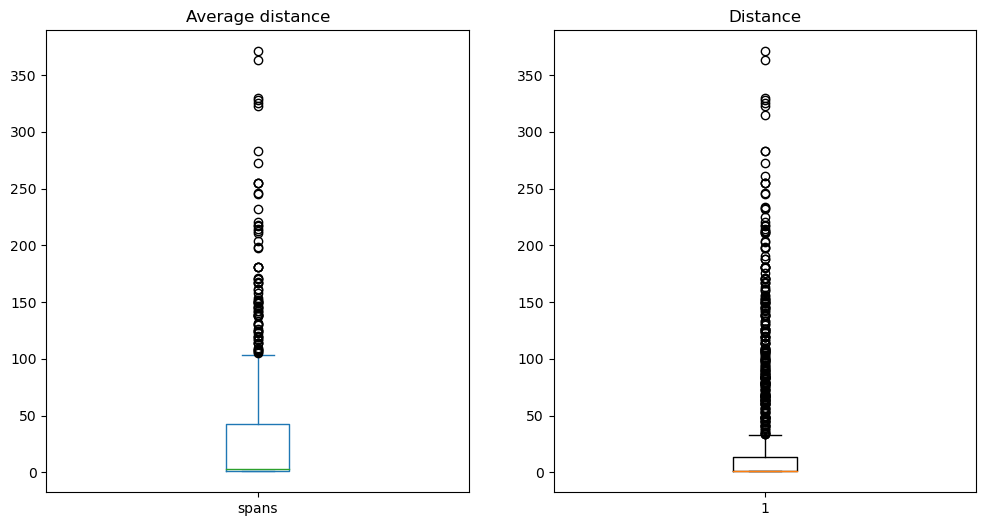

In [175]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

df_multispan.spans.apply(compute_distances).apply(np.mean).plot.box(ax=axs[0])

distances = df_multispan.spans.apply(compute_distances).agg(np.sum)
axs[1].boxplot(distances)

axs[0].set_title("Average distance")
axs[1].set_title("Distance")

fig.show()

In [158]:
df_multispan[df_multispan.spans.apply(lambda x: np.mean(x) < 10)]

,question,query_id,passages,answers,query_type,spans
19352,what is a b.a. vs b.s degree,1158893,"[{'is_selected': 0, 'passage_text': 'The Bache...",[B.A. means Bachelor of Arts degree and B.S. m...,DESCRIPTION,"[(0, 1), (2, 3), (9, 10)]"
21185,what is trade difference between china and us,1148399,"[{'is_selected': 0, 'passage_text': 'More info...",[The U.S. trade deficit with China is $347 bil...,DESCRIPTION,"[(0, 5), (6, 7)]"
22757,who is the best dermatologist,1039448,"[{'is_selected': 0, 'passage_text': 'Our derma...",[Dr. Daniel Taheri.],PERSON,"[(0, 2), (3, 17)]"
22952,who the top urologist affiliated with morristo...,1052848,"[{'is_selected': 0, 'passage_text': 'Search or...",[Dr. Philip A. Serbin MD is the top urologist ...,PERSON,"[(0, 2), (3, 12)]"
27181,what was the bloodiest one day confrontation i...,919667,"[{'is_selected': 0, 'passage_text': '150 years...","[Sept.17, 1862]",DESCRIPTION,"[(2, 6), (8, 16)]"
35659,what was et's favorite candy,1012863,"[{'is_selected': 0, 'passage_text': 'The film ...",[E.T.'s favorite candy was Reese's Pieces.],ENTITY,"[(1, 2), (15, 16)]"


## Other


# Preprocessing pipeline

- [x] Drop `wellFormedAnswers` column
- [ ] Drop row when `len(answers)`$>1$
- [x] Drop row when either `''` or `No Answer Present.` is the answer and there is at least one passage selected (row 28271)


TODO

- [ ] "No Answer Present" elements
- [ ] Number of unique "query_type"
